In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from ast import arg
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy

def fit(xs, y, optim_f, init_grid, top_k=500, n_proc=8, tol=None, disp=False, maxiter=None):
        _, _, brute_xs, brute_ys = scipy.optimize.brute(optim_f, init_grid, args=(xs, y), full_output=True, finish=None, Ns=1, workers=-1)

        brute_xs = brute_xs.reshape(brute_xs.shape[0], -1)
        brute_ys = brute_ys.reshape(-1)

        top_idxs = np.argsort(brute_ys)[:top_k]
        top_xs = brute_xs[:, top_idxs]
        # top_ys = brute_ys[top_idxs]
        preds = []
        for i in tqdm(range(top_xs.shape[1])):
            options = {'disp': disp}
            if maxiter: options['maxiter'] = maxiter
            pred = scipy.optimize.minimize(optim_f, top_xs[:, i], args=(xs, y), method='L-BFGS-B', tol=tol, options=options).x
            loss = optim_f(pred, xs, y)
            # print(pred, loss)
            preds.append((pred, loss))
        return sorted(preds, key=lambda x: x[1])[0][0]

def power_law_with_const_min(args, *params):
    x,y = params
    a,b,c = args
    # return ((power_law_with_const(x,a,b,c) - y) ** 2).mean()
    return ((np.log(power_law_with_const(x,a,b,c) / y)) ** 2).mean()

def power_law_with_const(x, a, b, c): return c + (x/b)**(-a)


27.472123918445998
0.0021486636720810383 loss
y = -1.73e+00 + (x/2.73e+04)^-1.24e-01


/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


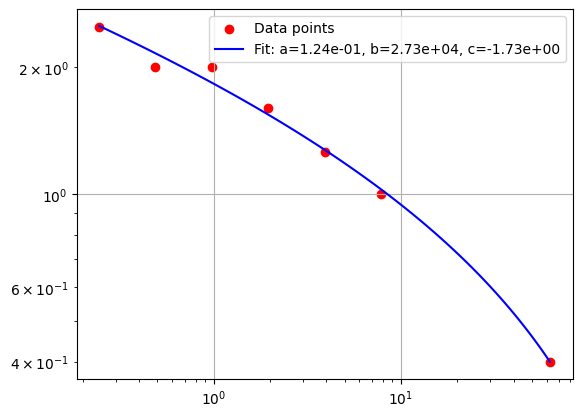

In [14]:
# learning rate - minimize()

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])/1000
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4]) * 10000

optim_f = power_law_with_const_min
current_params = [-2.50000000e+00,  4.75000000e+00,  1e-04]
print(optim_f(current_params, utd, learning_rate))
lbfgs_pred = scipy.optimize.minimize(optim_f, current_params, args=((utd,), learning_rate), method='L-BFGS-B', tol=1e-10).x
# print(lbfgs_pred)
print(optim_f(lbfgs_pred, utd, learning_rate), 'loss')

# Plot the fit
x_smooth = np.logspace(np.log10(np.min(utd)), np.log10(np.max(utd)), 100)
y_fitted = power_law_with_const(x_smooth, *lbfgs_pred)

plt.figure()
plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth, y_fitted, 'b-', label=f'Fit: a={lbfgs_pred[0]:.2e}, b={lbfgs_pred[1]:.2e}, c={lbfgs_pred[2]:.2e}')
print(f'y = {lbfgs_pred[2]:.2e} + (x/{lbfgs_pred[1]:.2e})^-{lbfgs_pred[0]:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()



  6%|▋         | 8/125 [00:00<00:03, 36.07it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
 26%|██▋       | 33/125 [00:00<00:01, 47.86it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
100%|██████████| 125/125 [00:02<00:00, 52.97it/s]


0.002654084755498555 loss
y = -1.30e+00 + (x/2.80e+03)^-1.43e-01


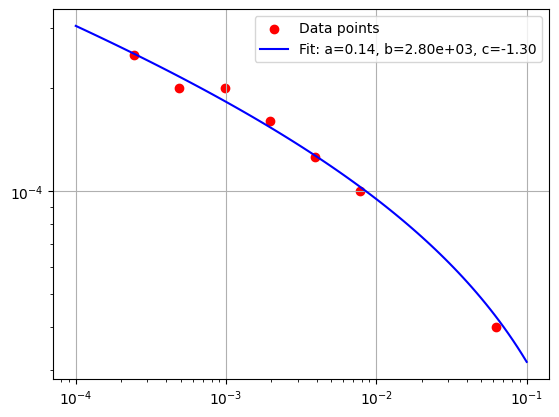

In [21]:
# learning rate - fit()

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
fit_data_points = [1, 2, 3, 4, 5, 6]

rescaling = [1000, 10000]
fitted_params = fit(utd[fit_data_points] * rescaling[0], learning_rate[fit_data_points] * rescaling[1], power_law_with_const_min,
                     [slice(-4, 4, 1.6),slice(1, 10, 2),slice(1e-5, 5e-4, 1e-4)], disp=False, maxiter=100)
print(power_law_with_const_min(fitted_params, utd[fit_data_points] * rescaling[0], learning_rate[fit_data_points] * rescaling[1]), 'loss')

x_smooth = np.logspace(-1, 2, 100)
a, b, c = fitted_params
y_fitted = power_law_with_const(x_smooth, a, b, c)

plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth / rescaling[0], y_fitted / rescaling[1], 'b-', label=f'Fit: a={a:.2f}, b={b:.2e}, c={c:.2f}')
print(f'y = {c:.2e} + (x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()



  0%|          | 0/125 [00:00<?, ?it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 125/125 [00:01<00:00, 122.57it/s]


loss 0.00893393442126563
y = 2.80e+00 / (1 + x/4.80e-01)^-3.56e-01


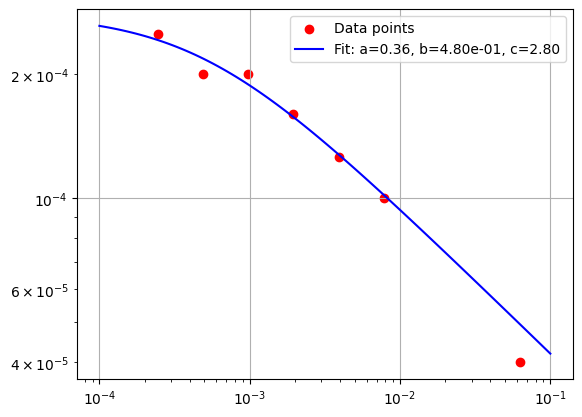

In [26]:
# large-batch training - fit()

def lr_rule_min(args, *params):
    x,y = params
    a,b,c = args
    return ((lr_rule(x,a,b,c) - y) ** 2).mean()
    # return ((np.log(lr_rule(x,a,b,c) / y)) ** 2).mean()

def lr_rule(x, a, b, c):
    return c * (1 + x/b) ** (-a)

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
fit_data_points = [1, 2, 3, 4, 5, 6]

scaling = [1000, 10000]
fitted_params = fit(utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1], lr_rule_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', lr_rule_min(fitted_params, utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-1, 2, 100)
y_fitted = lr_rule(x_smooth, a, b, c)

plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'Fit: a={a:.2f}, b={b:.2e}, c={c:.2f}')
print(f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

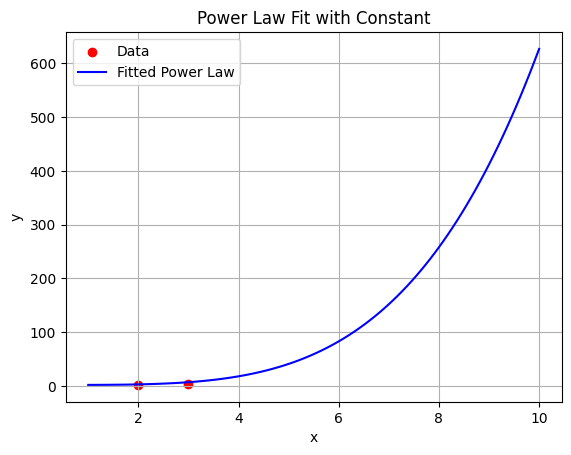

In [5]:
import numpy as np
from scipy import optimize
params = ((2,2), (3,3))

def power_law_with_const(x, a, b, c):
    return c + (x/b)**(-a)

def power_law_with_const_min(args, *params):
    x,y = params
    a,b,c = args
    return ((c + (x/b)**(-a) - y) ** 2).mean()

def f(args, *params):
    x, y = params
    a, b, c = args
    return (x * a**2 + y * b + c)

rranges = (slice(-4, 4, 0.25),slice(1e-18, 4, 0.25),slice(-4, 4, 0.25))
resbrute = optimize.brute(power_law_with_const_min, rranges, args=params, full_output=True, finish=optimize.fmin)
resbrute[0], resbrute[1]

import matplotlib.pyplot as plt

# Generate x values for smooth curve
x_plot = np.linspace(1, 10, 100)

# Get optimal parameters from brute force optimization
a_opt, b_opt, c_opt = resbrute[0]

# Calculate fitted y values
y_plot = power_law_with_const(x_plot, a_opt, b_opt, c_opt)

# Plot original data points
plt.scatter(*zip(*params), color='red', label='Data')

# Plot fitted curve
plt.plot(x_plot, y_plot, 'b-', label='Fitted Power Law')

plt.xlabel('x')
plt.ylabel('y') 
plt.title('Power Law Fit with Constant')
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
# loglog linear fit

logx = np.log(x)
logy = np.log(y)
# Fit a line
print(logx.shape, logy.shape)
a, b = np.polyfit(logx[0], logy, 1)
c = 0

x_smooth = np.logspace(-4, -1.15, 100)
y_fitted = np.exp(a*np.log(x_smooth) + b)
# y_fitted = power_law_with_const(x_smooth, a, b, c)
print(a, b, c, x_smooth, y_fitted)

/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in power


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

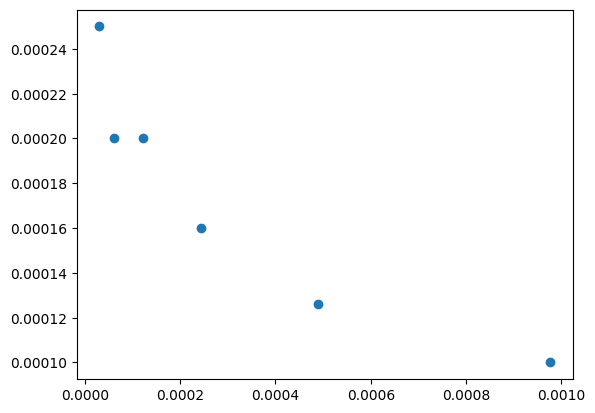

In [56]:
# Curve fit

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
n_parallel = np.array([ 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel
learning_rate = np.array([ 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
plt.scatter(utd, learning_rate)


def power_law_with_const(x, a, b, c):
    return c + (x/b)**(-a)
scaling = [1000, 10000]
popt, pcov = curve_fit(power_law_with_const, utd * scaling[0], learning_rate * scaling[1], p0=[0.25, 1e-5, 1e-5], maxfev=100000)

utd = np.linspace(1e-1, 1e-5)
plt.plot(utd, power_law_with_const(utd, *popt), linestyle='--')
print(f"y = {popt[2]:.2e} + (x/{popt[1]:.2e})^-{popt[0]:.2e}")

plt.xscale('log')
plt.yscale('log')
plt.ylabel('learning rate')
plt.xlabel('utd')